In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
from tqdm import tqdm
import cosmohmc.almncl.utils as utils
import cosmohmc.almncl.sampler as sampler 
import matplotlib.pyplot as plt


In [2]:
#number of alms for given elmax
elmax = 16
n_alms = int((elmax+1)*(elmax+2)/2)

In [3]:
nside = elmax
sigma = 3.0
noise_sigma = sigma*np.ones(hp.nside2npix(nside))
noise_var = sigma**2 *np.ones(hp.nside2npix(nside))
mask = np.ones(hp.nside2npix(nside))
npix = hp.nside2npix(nside)

In [4]:
#mock angular power spectra
elmax = 16
nside = elmax
el = np.arange(0, elmax+1, 1)
Cl_th = np.ndarray(shape = (elmax+1))
#monopole and dipole = 0
Cl_th[0] = 0.0
Cl_th[1] = 0.0
#constant power spectrum
Cl_th[2:] = 6.0
#power law power spectrum
#Cl_th[2:] = 5.0/el[2:]**(0.1)

In [5]:
def pdot_alm_v2(q_almr, q_almi, d_almr, d_almi, q_cl, Nl, n_alms):
    """Input:q_almr, q_almi, d_almr, d_almi, q_cl, Nl, n_alms. 
    Output: momentum derivative for real and imaginary part of alms- p_almr_dot & p_almi_dot."""
    p_almr_d = np.zeros(n_alms)
    p_almi_d = np.zeros(n_alms)
    RSMapr = np.zeros(n_alms)
    RSMapi = np.zeros(n_alms)
   
    for k in range(3, n_alms):
        l, m = utils.n2lm_index(k)
        RSMapr[k] = - q_almr[k] / q_cl[l]
        RSMapi[k] = - q_almi[k] / q_cl[l]
        
        #for k in range(3, n_alms):
        #    l,m = utils.n2lm_index(k)
            
    dfalm = utils.reconstruct_alm_from_2d(d_almr-q_almr, d_almi-q_almi, elmax)
        
    map_T = hp.alm2map(dfalm, nside = nside)
    map2 = map_T * mask / noise_var
    dfalm = hp.map2alm(map2, lmax = elmax)
    dfQr, dfQi = utils.convert_alm_to_2d(dfalm, elmax) 
    dfQr = dfQr * npix / 4 / np.pi
    dfQi = dfQi * npix / 4 / np.pi

 #   for k in np.arange(3, n_alms, 1):
 #       l,m = utils.n2lm_index(k) 
 #       dfQr[k] = dfQr[k]/Nl[l]
 #       dfQi[k] = dfQi[k]/Nl[l]        
       
    
    for k in range(3, n_alms):
        l, m = utils.n2lm_index(k)
        if m == 0:
            p_almr_d[k] = RSMapr[k] + dfQr[k]
            p_almi_d[k] = 0.0
        else:
            p_almr_d[k] = 2*RSMapr[k] + 2*dfQr[k]
            p_almi_d[k] = 2*RSMapi[k] + 2*dfQi[k]
    return p_almr_d, p_almi_d

In [6]:
np.random.seed(10)
map_sig, alm_sig = hp.synfast(cls = Cl_th, nside = nside, lmax=elmax, mmax=elmax, alm=True,
    pol=False, pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)

In [7]:
#compute realization angular power spectrum
map_Cl = hp.anafast(map_sig, lmax=elmax, mmax = elmax, alm=False, pol=False)

In [8]:
np.random.seed(20)
map_noise  = np.random.normal(0, sigma, hp.nside2npix(nside))

In [9]:
#compute power spectra of noise realization
noise_Nl = hp.anafast(map_noise, lmax=elmax, mmax = elmax, alm=False, pol=False)
#noise_Nl = 4 * np.pi * sigma**2 / npix * np.ones(elmax+1)
noise_Nl_th = 4 * np.pi * sigma**2 / npix * np.ones(elmax+1)

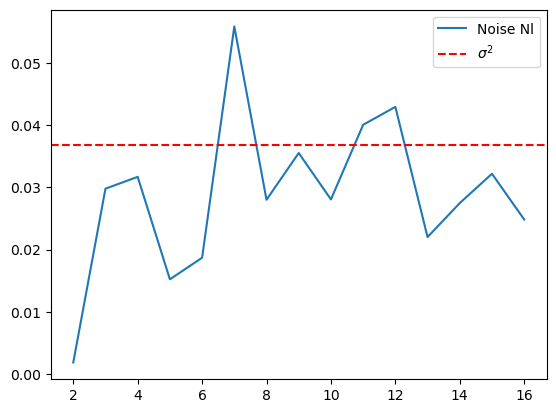

In [10]:
#plt.plot(el[2:], Nl[2:], label = "Nl")
plt.plot(el[2:], noise_Nl[2:], label = "Noise Nl")
plt.axhline(y = 4 * np.pi * sigma**2 / npix, color = 'r', linestyle = '--', label = r'$\sigma^{2}$')
plt.legend()

In [11]:
map_data = map_sig + map_noise
alm_data = hp.map2alm(map_data, lmax=elmax, mmax=elmax)

In [12]:
#compute data angular power spectrum
data_cl = hp.alm2cl( alms1 = alm_data, alms2=None, lmax=elmax, mmax=elmax, lmax_out=elmax,nspec=None)

In [13]:
#define required arrays
#alm position
q_almr = np.ndarray(shape = (n_alms))
q_almi = np.ndarray(shape = (n_alms))
p_almr = np.ndarray(shape = (n_alms))
p_almi = np.ndarray(shape = (n_alms))

#for alm velocity: alm momentum divided by alm mass
q_almr_dot = np.ndarray(shape = (n_alms))
q_almi_dot = np.ndarray(shape = (n_alms))
p_almr_dot = np.ndarray(shape = (n_alms))
p_almi_dot = np.ndarray(shape = (n_alms))

#for Cl
q_cl = np.ndarray(shape = (elmax+1))
p_cl = np.ndarray(shape = (elmax+1))
q_cl_dot = np.ndarray(shape = (elmax+1))
p_cl_dot = np.ndarray(shape = (elmax+1))

d_almr, d_almi = utils.convert_alm_to_2d(alm_data, elmax)

In [14]:
#mass matrix for Cl
m_cl = np.ndarray(shape = (elmax+1))
m_cl.fill(1.0)
m_cl[2:] = utils.mass_cl(el[2:], map_Cl[2:], noise_Nl[2:])

m_almr, m_almi = utils.mass_alm(map_Cl, noise_Nl, n_alms) #use signal realization Cl


In [15]:
#HMC parameters
#stepsize
eps = 0.1
#number of leap frog steps
N_lf = 10
#number of samples t""o be computed
N_samples = 100

In [16]:
#array to store the parameter samples
sample_q_almr = np.ndarray(shape = (N_samples, n_alms) )
sample_q_almi = np.ndarray(shape = (N_samples, n_alms) )
sample_q_cl = np.ndarray(shape = (N_samples, elmax + 1) )
#array to store samples of realization Cl [not a sampling parameter]
sample_hat_cl = np.ndarray(shape = (N_samples, elmax + 1) )
#momentum samples, helps with troubleshooting
#sample_p_almr = np.ndarray(shape = (N_samples, n_alms) )
#sample_p_almi = np.ndarray(shape = (N_samples, n_alms) )
sample_p_cl = np.ndarray(shape = (N_samples, elmax + 1) )

Uniform_rand_num = np.random.uniform(0.0, 1.0, N_samples)

#arrays to store Hamiltonian/energy related variables, some for the help with troubleshooting
dH_array = np.ndarray(shape = (N_samples))
KE_array = np.ndarray(shape = (N_samples, 2))
PE_array = np.ndarray(shape = (N_samples, 2))
H0_array = np.ndarray(shape = (N_samples))
Hstar_array = np.ndarray(shape = (N_samples))
dH_array[0] = 0.0
H0_array[0] = 0.0
Hstar_array[0] = 0.0

#Preparation for HMC 

#Initialise the loop
q_cl = np.copy(map_Cl)
q_almr = np.copy(d_almr)
q_almi = np.copy(d_almi)

#just as a placeholder value
q_cl_star = np.copy(q_cl)
q_almr_star = np.copy(q_almr)
q_almi_star = np.copy(q_almi)

#Draw the momentum
p_almr, p_almi = utils.momentum_alm(m_almr, m_almi, n_alms)
p_cl = utils.momentum_cl(m_cl, elmax)

#Compute Hamiltonian for the starting point
####################
KE_term =  utils.KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms)
Cl_hat = np.copy(map_Cl)

Dl_hat = utils.Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax) #np.copy(noise_Nl)
PE_term = utils.PE(Cl_hat, Dl_hat, Cl_th, noise_Nl)
#PE_term = utils.PE_pix(Cl_hat, utils.reconstruct_alm_from_2d(q_almr, q_almi, elmax), utils.reconstruct_alm_from_2d(d_almr, d_almi, elmax), Cl_th, noise_sigma, nside)
H_star = KE_term + PE_term

In [17]:
Dl_hat = utils.Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax) #np.copy(noise_Nl)
PE_term = utils.PE(Cl_hat, Dl_hat, Cl_th, noise_Nl)
PE_term_1 = utils.PE_pix(Cl_hat, utils.reconstruct_alm_from_2d(q_almr, q_almi, elmax), utils.reconstruct_alm_from_2d(d_almr, d_almi, elmax), Cl_th, noise_sigma, nside)
PE_term_2, dismod2 = utils.PE_pix_v3(Cl_hat, utils.reconstruct_alm_from_2d(q_almr, q_almi, elmax), utils.reconstruct_alm_from_2d(d_almr, d_almi, elmax), Cl_th, noise_Nl_th)



In [18]:
PE_term, PE_term_1, PE_term_2

(381.03000685728085, 381.03000685728085, 381.03000685728085)

In [19]:
PE_term

381.03000685728085

In [20]:
diff = utils.reconstruct_alm_from_2d(q_almr, q_almi, elmax) - utils.reconstruct_alm_from_2d(d_almr, d_almi, elmax)

In [21]:
diff

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

In [25]:
#initialise the chain
sample_q_almr[0,3:] = np.copy(q_almr[3:])
sample_q_almi[0,3:] = np.copy(q_almi[3:])
sample_q_cl[0,2:] = np.copy(q_cl[2:])

accept_count = 0

#HMC loop

for i in tqdm(np.arange(1, N_samples, 1)):
    #print(i)
    #Draw the momentum
    p_almr, p_almi = utils.momentum_alm(m_almr, m_almi, n_alms)
    p_cl = utils.momentum_cl(m_cl, elmax)
    if i == 1:
        sample_p_cl[0, 2:] = p_cl[2:]
    KE_term0 = utils.KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms)
    
    Dl_hat = utils.Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax)
    Cl_hat = utils.Cl_of_almri(q_almr, q_almi, elmax)
    PE_term0 = utils.PE(Cl_hat, Dl_hat, q_cl, noise_Nl_th)
    #PE_term0 = utils.PE_pix(Cl_hat, utils.reconstruct_alm_from_2d(q_almr, q_almi, elmax), utils.reconstruct_alm_from_2d(d_almr, d_almi, elmax), q_cl, noise_sigma, nside)
    KE_array[i, 0] = KE_term0
    PE_array[i, 0] = PE_term0
    H0 = KE_term0 + PE_term0
    H0_array[i] = H0
    
    #p_cl, p_almr, p_almi, q_cl, q_almr, q_almi = hmc_sampler.leapfrog_v2(p_cl, p_almr, p_almi, q_cl, q_almr, q_almi)    
    for j in np.arange(0, N_lf, 1):
        
        #half position step
        q_cl_dot = p_cl/m_cl
        q_cl = q_cl + q_cl_dot*eps*0.5
        
        q_almr_dot = p_almr/m_almr
        q_almi_dot = p_almi/m_almi
        
        q_almr = q_almr + q_almr_dot*eps*0.5
        q_almi = q_almi + q_almi_dot*eps*0.5
        
        #momentum step
        #compute p_cl_dot
        Cl_hat = utils.Cl_of_almri(q_almr, q_almi, elmax)
        p_cl_dot = utils.pdot_cl(el, Cl_hat, q_cl)
        
        p_cl = p_cl + p_cl_dot*eps
        
        #compute p_almr_dot, p_almi_dot
        p_almr_dot, p_almi_dot = pdot_alm_v2(q_almr, q_almi, d_almr, d_almi, q_cl, noise_Nl, n_alms)
        
        p_almr = p_almr + p_almr_dot*eps
        p_almi = p_almi + p_almi_dot*eps
        
        #half position step
        q_cl_dot = p_cl/m_cl
        q_cl = q_cl + q_cl_dot*eps*0.5
        
        q_almr_dot = p_almr/m_almr
        q_almi_dot = p_almi/m_almi
        
        q_almr = q_almr + q_almr_dot*eps*0.5
        q_almi = q_almi + q_almi_dot*eps*0.5
            
    #Metropolis rule
    Cl_hat = utils.Cl_of_almri(q_almr, q_almi, elmax)
    KE_term_star = utils.KE(p_cl, p_almr, p_almi, m_cl, m_almr, m_almi, n_alms)
    Dl_hat = utils.Cl_of_almri(d_almr - q_almr, d_almi - q_almi, elmax)
    PE_term_star = utils.PE(Cl_hat, Dl_hat, q_cl, noise_Nl_th)
    #PE_term_star = utils.PE_pix(Cl_hat, utils.reconstruct_alm_from_2d(q_almr, q_almi, elmax), utils.reconstruct_alm_from_2d(d_almr, d_almi, elmax), q_cl, noise_sigma, nside)

    
    KE_array[i, 1] = KE_term_star
    PE_array[i, 1] = PE_term_star
    
    H_star = KE_term_star + PE_term_star
    Hstar_array[i] = H_star
    dH_array[i] = H0 - H_star
    
    sample_hat_cl[i, 2:] = np.copy(Cl_hat[2:])
    
    if np.log(Uniform_rand_num[i]) < (H0 - H_star):
        #accept the proposed sample
        sample_q_almr[i,:] = np.copy(q_almr[:])
        sample_q_almi[i,:] = np.copy(q_almi[:])
        sample_q_cl[i,:] = np.copy(q_cl[:])
        #also store the Cl momentum
        sample_p_cl[i, :] = np.copy(p_cl[:])
        H0 = H_star
        accept_count += 1
    else:
        #new sample equal to the previous accepted sample
        sample_q_cl[i,:] = np.copy(sample_q_cl[i-1,:])
        sample_q_almr[i,:] = np.copy(sample_q_almr[i-1,:])
        sample_q_almi[i,:] = np.copy(sample_q_almi[i-1,:])
        #also store the Cl momentum
        sample_p_cl[i, :] = np.copy(sample_p_cl[i-1, :])
        #reset the variables
        q_cl = np.copy(sample_q_cl[i-1,:])
        q_almr = np.copy(sample_q_almr[i-1,:])
        q_almi = np.copy(sample_q_almi[i-1,:])
    #sample_q_cl[i,2:] = np.copy(q_cl[2:])
print(accept_count)

100%|██████████| 99/99 [00:04<00:00, 24.65it/s]

96


In [26]:
H0_array,Hstar_array, dH_array

(array([  0.        , 656.38245235, 687.67069812, 688.01238628,
        668.08316813, 669.25303666, 674.67483875, 676.66421384,
        677.60833983, 694.10435412, 663.20402907, 679.14876809,
        687.87827949, 674.98408404, 676.21763382, 675.49352504,
        664.97090355, 679.4449759 , 705.49841637, 672.70147978,
        652.87306263, 703.35321173, 704.4748    , 691.49384199,
        666.90409823, 652.52458396, 655.36932675, 676.09846192,
        676.5554625 , 684.05112905, 685.6340518 , 695.46648178,
        715.59608273, 710.64681017, 694.1532016 , 684.49604513,
        683.75365132, 692.03567306, 697.26559879, 689.12580566,
        687.33113828, 684.47816527, 679.78430821, 710.17532403,
        671.31819897, 689.36878732, 677.09019928, 654.01234175,
        666.14060218, 660.75883855, 659.00822447, 637.57346368,
        652.71557193, 662.00894968, 638.89810217, 647.65626849,
        667.17684476, 671.01734252, 666.52696022, 685.3094139 ,
        665.19867136, 653.85861314, 681.